# Identify underperforming crops from the provided raster dataset.



Band 3: Crop type predictions.

Band 4: Model confidence scores for Band 3.

Summarize these values at the field level and compare them against ground truth data list as 2 as follows.

In [40]:
%load_ext autoreload
%autoreload 2

import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd

from src.constants import LABELS_INDEX, TWO_WAY_LABELS_DICT, MISSING_VALUE, CROP_TYPE_PREDICTION_INDEX_BAND, CROP_TYPE_PREDICTION_CONFIDENCE_BAND
from src.common.utils import get_utm_zone_epsg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## u0e

In [2]:
u0e_analysis = gpd.read_file('/code/support_files/u0e_gt_model_example.gpkg')
u0e_analysis

field_id       area_m2 normalized_label  year  \
0   3b3a7827-6149-4733-951b-eae1d65c5ff2   2871.587981    barley_spring  2022   
1   4b0b7266-62df-4a29-939c-fb757c965351  90370.992230    barley_spring  2022   
2   db51efee-b88c-4611-b9e5-db029ef4560a  14131.292570    barley_spring  2022   
3   5c309910-7dea-410b-8756-a579b0906976  22592.181240    barley_spring  2022   
4   2f7d55c3-33bb-4e3c-962f-e697ae2a6b9d  36978.161367    barley_spring  2022   
..                                   ...           ...              ...   ...   
70  db54de67-c7d6-4760-8f06-7946b079f597  61250.037319    barley_spring  2022   
71  da83fe95-fd9a-4e6d-a2d9-ce5546de6a6d  96006.025520    barley_spring  2022   
72  a34709e8-3193-4971-946c-2fc4eba72f80  24308.217631    barley_spring  2022   
73  508c042c-8c1c-4e7e-8926-40f648929e3d  44889.804598    barley_spring  2022   
74  eb64f4db-e49c-473c-9fb2-5845a883a7da  66735.796171    barley_spring  2022   

    majority_crop  confidence_score majority_crop_label       gt_label  \
0            28.0         53.750000              Fallow  Spring Barley   
1             6.0         48.722222       Spring Barley  Spring Barley   
2             5.0         52.857143       Winter Barley  Spring Barley   
3             5.0         55.558824       Winter Barley  Spring Barley   
4             6.0         47.627907       Spring Barley  Spring Barley   
..            ...               ...                 ...            ...   
70            5.0         36.625000       Winter Barley  Spring Barley   
71            6.0         69.794702       Spring Barley  Spring Barley   
72            5.0         49.884615       Winter Barley  Spring Barley   
73            6.0         48.534884       Spring Barley  Spring Barley   
74            6.0         56.368932       Spring Barley  Spring Barley   

    gt_ml_match                                           geometry  
0             0  POLYGON ((4.29005 48.82525, 4.2898 48.82555, 4...  
1             1  POLYGON ((4.27618 48.96187, 4.27595 48.96174, ...  
2             0  POLYGON ((4.22832 48.65064, 4.21998 48.6477, 4...  
3             0  POLYGON ((4.30365 48.99449, 4.30199 48.99337, ...  
4             1  POLYGON ((4.25154 49.09641, 4.25068 49.1045, 4...  
..          ...                                                ...  
70            0  POLYGON ((4.23295 48.69991, 4.23314 48.70016, ...  
71            1  POLYGON ((4.25093 49.00886, 4.25077 49.00845, ...  
72            0  POLYGON ((4.31396 49.03012, 4.31467 49.03019, ...  
73            1  POLYGON ((4.31371 49.0336, 4.31396 49.03368, 4...  
74            1  POLYGON ((4.3409 49.15498, 4.3392 49.15418, 4....  

[75 rows x 10 columns]

In [3]:
len(u0e_analysis['majority_crop'].unique())

5

In [4]:
u0e_performance = pd.read_csv('/code/support_files/u0e_gt_crop_and_crop_confidence_fr.csv')
u0e_performance

crop  num_fields  agreement_score  weighted_f1_score
0          Canola        4547             0.99               1.00
1        Vineyard        2848             0.98               0.99
2      Sugarbeets        2343             0.97               0.99
3    Winter Wheat       17057             0.97               0.98
4        Potatoes         359             0.95               0.98
5   Winter Barley        6798             0.94               0.97
6      Sunflowers        3287             0.92               0.96
7     Silage Corn        2125             0.86               0.93
8         Lentils         503             0.87               0.93
9         Alfalfa        4435             0.86               0.92
10           Peas         285             0.86               0.92
11       Soybeans         343             0.80               0.89
12     Grain Corn        2884             0.69               0.82
13         Fallow       11236             0.68               0.81
14  Spring Barley       10124             0.48               0.65
15         Clover        1152             0.46               0.63
16       Ryegrass         286             0.47               0.63
17           Flax         160             0.42               0.59
18    Spring Oats         723             0.40               0.57
19      Triticale         456             0.31               0.48
20         Millet          10             0.30               0.46
21        Sorghum          54             0.28               0.43
22    Winter Oats         172             0.13               0.24
23   Spring Wheat         346             0.00               0.01
24          Trees         646             0.00               0.00
25     Winter Rye         153             0.00               0.00
26        Turnips           1             0.00               0.00
27     Spring Rye           5             0.00               0.00
28          Beans           7             0.00               0.00

**performance was on 29 classes**

## u0c

In [5]:
! gdalinfo /code/data/ml_2021-08-01_2022-12-31_u0c.tif

Driver: GTiff/GeoTIFF
Files: /code/data/ml_2021-08-01_2022-12-31_u0c.tif
Size is 5429, 5361
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.

ml_2021-08-01_2022-12-31_u0c.tif represents the inference outputs

In [41]:
model_prediction_ds = rasterio.open("/code/data/ml_2021-08-01_2022-12-31_u0c.tif")
predictions = model_prediction_ds.read(CROP_TYPE_PREDICTION_INDEX_BAND)
confidence = model_prediction_ds.read(CROP_TYPE_PREDICTION_CONFIDENCE_BAND)
len(np.unique(predictions))

28

In [42]:
predictions.max()

np.int16(31)

In [43]:
pred_class_count = dict()
for pred_idx, pred_class in enumerate(LABELS_INDEX):
    n_pred_for_class = predictions.flatten() == pred_idx
    n_pix_pred = np.sum(n_pred_for_class)
    pred_class_count[pred_class] = n_pix_pred
    if n_pix_pred == 0:
        print(f"Model did not predict any pixels were {pred_idx}/{pred_class}")
    

pred_class_count

Model did not predict any pixels were 9/Winter Rye
Model did not predict any pixels were 10/Spring Rye
Model did not predict any pixels were 26/Beans
Model did not predict any pixels were 29/Turnips


{'Grassland Cultivated': np.int64(1570275),
 'Grassland Nature': np.int64(906),
 'Clover': np.int64(164513),
 'Alfalfa': np.int64(278775),
 'Ryegrass': np.int64(1647809),
 'Winter Barley': np.int64(1873166),
 'Spring Barley': np.int64(458172),
 'Winter Wheat': np.int64(7482974),
 'Triticale': np.int64(263930),
 'Winter Rye': np.int64(0),
 'Spring Rye': np.int64(0),
 'Spring Wheat': np.int64(3889),
 'Rice': np.int64(486),
 'Millet': np.int64(2664),
 'Sorghum': np.int64(11416),
 'Spring Oats': np.int64(103254),
 'Winter Oats': np.int64(59410),
 'Sunflowers': np.int64(214925),
 'Flax': np.int64(332261),
 'Canola': np.int64(1529485),
 'Grain Corn': np.int64(676798),
 'Silage Corn': np.int64(1550147),
 'Potatoes': np.int64(1211243),
 'Sugarbeets': np.int64(1531857),
 'Soybeans': np.int64(96415),
 'Peas': np.int64(559477),
 'Beans': np.int64(0),
 'Lentils': np.int64(34603),
 'Fallow': np.int64(7174046),
 'Turnips': np.int64(0),
 'Trees': np.int64(168966),
 'Vineyard': np.int64(103007)}

In [44]:
len(np.unique(predictions))

28

In [45]:
len(LABELS_INDEX)

32

Text(0.5, 0.98, 'predictions')

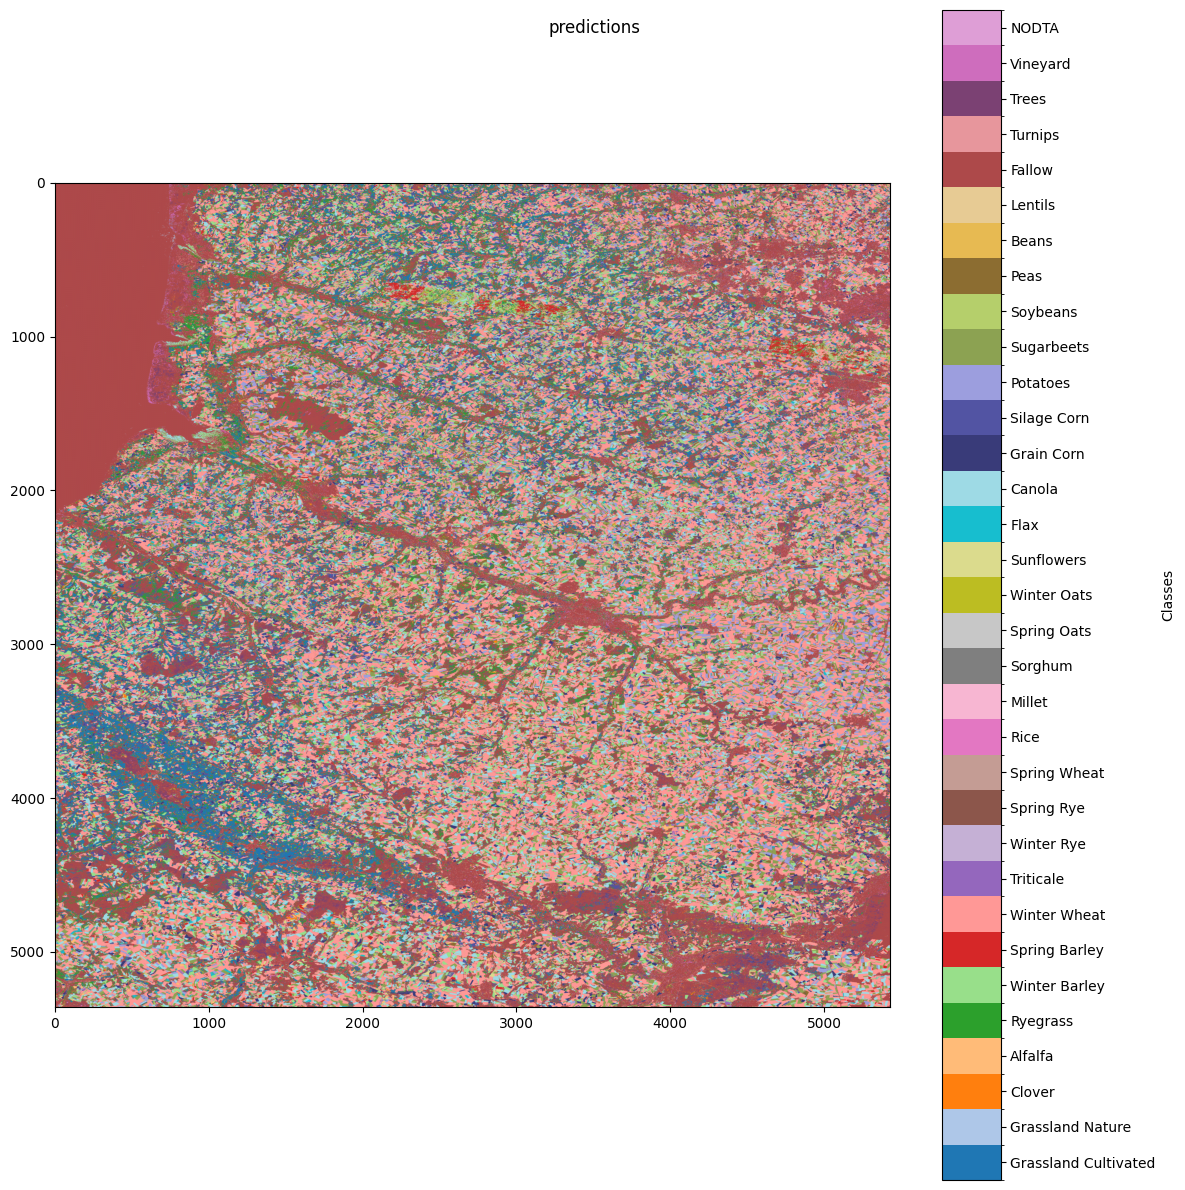

In [46]:
fig, ax = plt.subplots(1,1, figsize=(12, 12))
predicted_class_values = np.arange(len(LABELS_INDEX))
n_predicted_classes = len(predicted_class_values)

colors1 = plt.cm.tab20(np.linspace(0, 1, 20))
colors2 = plt.cm.tab20b(np.linspace(0, 1, n_predicted_classes-20 + 1)) # +1 for nodata
colors = np.vstack((colors1, colors2))
classes_cmap = ListedColormap(colors)
color_bounds = np.arange(-0.5, n_predicted_classes + 0.5 + 1) # +1 for nodata
classes_norm = BoundaryNorm(color_bounds, classes_cmap.N)

im = ax.imshow(predictions, cmap=classes_cmap, norm=classes_norm)
cbar = plt.colorbar(im, ticks=np.arange(n_predicted_classes+1)) # +1 for nodata
cbar.set_label('Classes')

category_labels = [LABELS_INDEX[ii] for ii in predicted_class_values] + ["NODTA"]

cbar.set_ticklabels(category_labels)

plt.tight_layout()
plt.suptitle("predictions")

In [47]:
ground_truth = gpd.read_file("/code/data/u0c_gt_filtered_2022.gpkg")
ground_truth['label'] = ground_truth['normalized_label'].apply(lambda x: TWO_WAY_LABELS_DICT.get(x, MISSING_VALUE))
valid_labels = ground_truth[ground_truth['label'] != MISSING_VALUE]
discarded_labels = ground_truth[ground_truth['label'] == MISSING_VALUE]

valid_labels['label_index'] = valid_labels['label'].apply(lambda x: LABELS_INDEX.index(x))

valid_labels

/usr/local/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


field_id       area_m2 normalized_label  \
0       0b6947ad-48c3-4d4e-8180-0c5511d53cfa   4725.570410         vineyard   
1       ce190383-0a9c-4e07-babd-84231bca342f   3977.850757         vineyard   
2       509fd0e1-1a5b-4c18-9c34-ac3f92e250b6  12203.754334         vineyard   
3       2f01fe6b-289d-45c0-976e-1c870921411f  14456.984724         vineyard   
4       e5b80722-6b71-4925-a3b9-b72c295da63c  10264.691558         vineyard   
...                                      ...           ...              ...   
153859  9e4331b3-7626-4cdb-9a23-a921c96b66e4   2816.240225           millet   
153860  454bac96-a987-41fa-891e-7d6fc2bd0dab   4968.793841           millet   
153861  1c7585ca-3330-4328-b203-ffd4c484c965   4661.246860           millet   
153862  113047e0-ee04-44cb-b087-04a1206df177   3030.348612           millet   
153863  8b2f1b87-c953-46f8-a443-6ffb5fed1597   3221.978022           millet   

        year                                           geometry     label  \
0       2022  POLYGON ((1.68069 49.39478, 1.6807 49.39475, 1...  Vineyard   
1       2022  POLYGON ((1.53424 49.52747, 1.53498 49.5276, 1...  Vineyard   
2       2022  POLYGON ((2.28742 49.73154, 2.28695 49.73236, ...  Vineyard   
3       2022  POLYGON ((2.28609 49.73127, 2.28555 49.73223, ...  Vineyard   
4       2022  POLYGON ((1.86942 50.25858, 1.8701 50.25966, 1...  Vineyard   
...      ...                                                ...       ...   
153859  2022  POLYGON ((1.82623 49.35807, 1.82604 49.35806, ...    Millet   
153860  2022  POLYGON ((1.80245 49.34628, 1.80238 49.34602, ...    Millet   
153861  2022  POLYGON ((1.81285 49.34484, 1.81309 49.34531, ...    Millet   
153862  2022  POLYGON ((1.81156 49.34383, 1.81155 49.34381, ...    Millet   
153863  2022  POLYGON ((1.83 49.35516, 1.83019 49.35505, 1.8...    Millet   

        label_index  
0                31  
1                31  
2                31  
3                31  
4                31  
...             ...  
153859           13  
153860           13  
153861           13  
153862           13  
153863           13  

[153862 rows x 7 columns]

In [48]:
discarded_labels

field_id       area_m2 normalized_label  \
42305  f2ef7379-925a-423a-b864-3bb1c67585c8  14687.123217           radish   
42306  9292b58a-18a3-4920-a3c2-2dc676900767  11536.496491           radish   

       year                                           geometry          label  
42305  2022  POLYGON ((2.03236 49.65503, 2.03262 49.65476, ...  MISSING_VALUE  
42306  2022  POLYGON ((2.44639 49.6617, 2.44601 49.66398, 2...  MISSING_VALUE

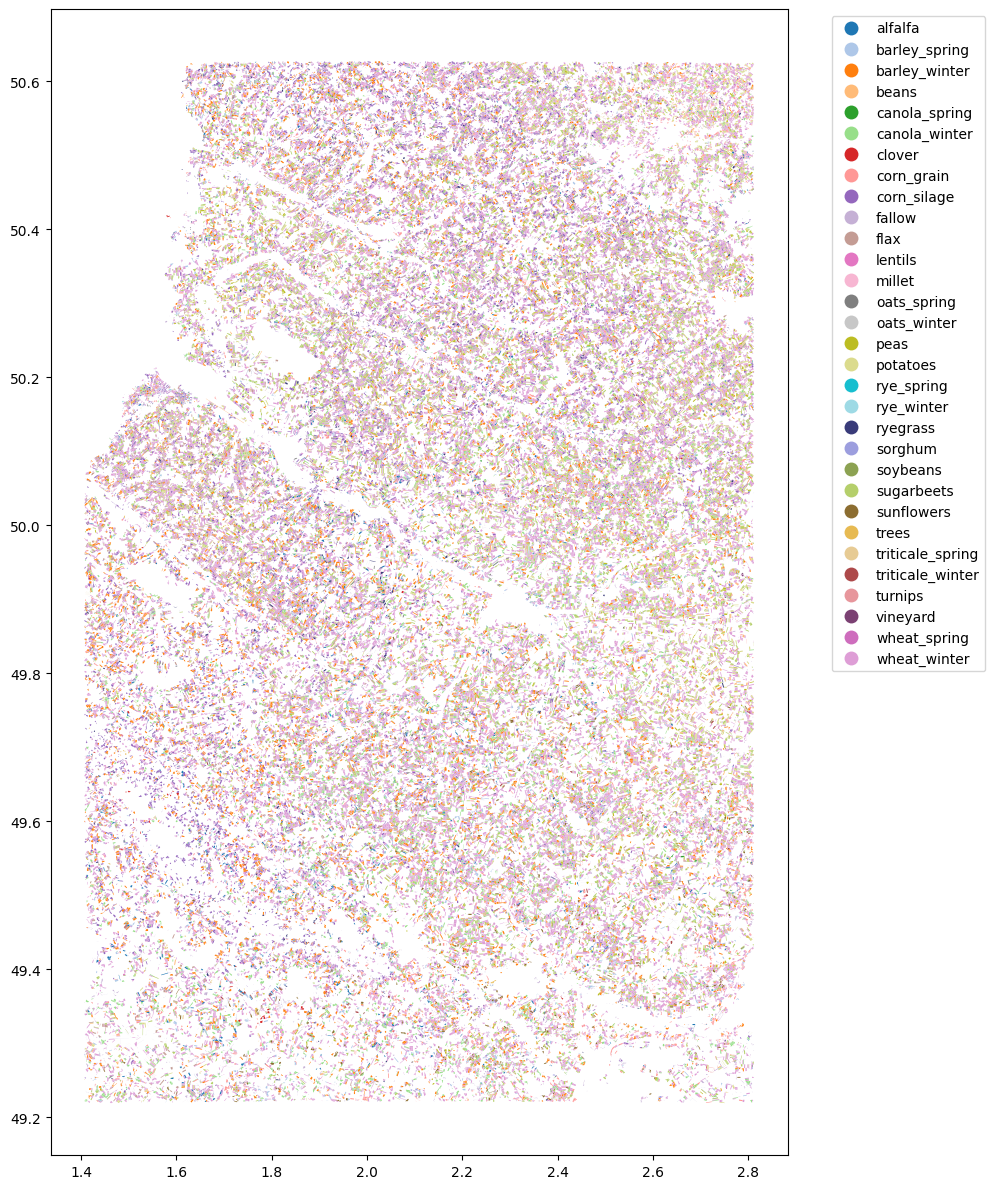

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

valid_labels.plot(column='normalized_label', 
        categorical=True,
        cmap=classes_cmap,
        legend=True,
        ax=ax,
        legend_kwds={'bbox_to_anchor': (1.05, 1),
                    'loc': 'upper left'})

plt.tight_layout()

In [50]:
from typing import Tuple
from typing import Union
from shapely.geometry import Polygon
import numpy as np


Bounds = Tuple[float, float, float, float]


def get_utm_zone_epsg(aoi: Union[Bounds, Polygon]):
    if isinstance(aoi, Tuple):
        minx, miny, maxx, maxy = aoi
    else:
        minx, miny, maxx, maxy = aoi.bounds

    lon = np.mean([minx, maxx])
    lat = np.mean([miny, maxy])

    utm_band = str(int((np.floor((lon + 180) / 6) % 60) + 1))
    if len(utm_band) == 1:
        utm_band = "0" + utm_band
    if lat >= 0:
        epsg_code = "326" + utm_band
    else:
        epsg_code = "327" + utm_band

    return np.int64(epsg_code)


valid_labels['utm_zone'] = valid_labels['geometry'].apply(get_utm_zone_epsg)
assert len(valid_labels['utm_zone'].unique()) == 1
valid_labels_utm = valid_labels.to_crs(f"EPSG:{valid_labels['utm_zone'].iloc[0]}")
valid_labels_utm

/usr/local/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


field_id       area_m2 normalized_label  \
0       0b6947ad-48c3-4d4e-8180-0c5511d53cfa   4725.570410         vineyard   
1       ce190383-0a9c-4e07-babd-84231bca342f   3977.850757         vineyard   
2       509fd0e1-1a5b-4c18-9c34-ac3f92e250b6  12203.754334         vineyard   
3       2f01fe6b-289d-45c0-976e-1c870921411f  14456.984724         vineyard   
4       e5b80722-6b71-4925-a3b9-b72c295da63c  10264.691558         vineyard   
...                                      ...           ...              ...   
153859  9e4331b3-7626-4cdb-9a23-a921c96b66e4   2816.240225           millet   
153860  454bac96-a987-41fa-891e-7d6fc2bd0dab   4968.793841           millet   
153861  1c7585ca-3330-4328-b203-ffd4c484c965   4661.246860           millet   
153862  113047e0-ee04-44cb-b087-04a1206df177   3030.348612           millet   
153863  8b2f1b87-c953-46f8-a443-6ffb5fed1597   3221.978022           millet   

        year                                           geometry     label  \
0       2022  POLYGON ((404268.582 5472180.18, 404269.028 54...  Vineyard   
1       2022  POLYGON ((393929.383 5487127.027, 393982.566 5...  Vineyard   
2       2022  POLYGON ((448647.881 5509026.005, 448614.949 5...  Vineyard   
3       2022  POLYGON ((448551.902 5508997.785, 448513.565 5...  Vineyard   
4       2022  POLYGON ((419410.858 5567992.878, 419461.431 5...  Vineyard   
...      ...                                                ...       ...   
153859  2022  POLYGON ((414765.721 5467924.036, 414751.703 5...    Millet   
153860  2022  POLYGON ((413018.164 5466640.589, 413012.548 5...    Millet   
153861  2022  POLYGON ((413770.73 5466468.806, 413789.133 54...    Millet   
153862  2022  POLYGON ((413675.198 5466358.334, 413674.511 5...    Millet   
153863  2022  POLYGON ((415034.465 5467596.285, 415047.72 54...    Millet   

        label_index  utm_zone  
0                31     32631  
1                31     32631  
2                31     32631  
3                31     32631  
4                31     32631  
...             ...       ...  
153859           13     32631  
153860           13     32631  
153861           13     32631  
153862           13     32631  
153863           13     32631  

[153862 rows x 8 columns]

In [53]:
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.warp import Resampling

with rasterio.open('/code/data/ml_2021-08-01_2022-12-31_u0c.tif') as src:
    vrt_options = {
        'resampling': Resampling.nearest,  # Choose resampling method
        'crs': f"EPSG:{valid_labels['utm_zone'].iloc[0]}",  # Target CRS
        'nodata': 255
    }
    
    with WarpedVRT(src, **vrt_options) as vrt:
        reprojected_predictions= vrt.read(3)
        reprojected_confidence = vrt.read(4)

vrt.transform

Affine(25.15402411011593, 0.0, 381836.7589501574,
       0.0, -25.15402411011593, 5611638.501946792)

Text(0.5, 0.98, 'predictions')

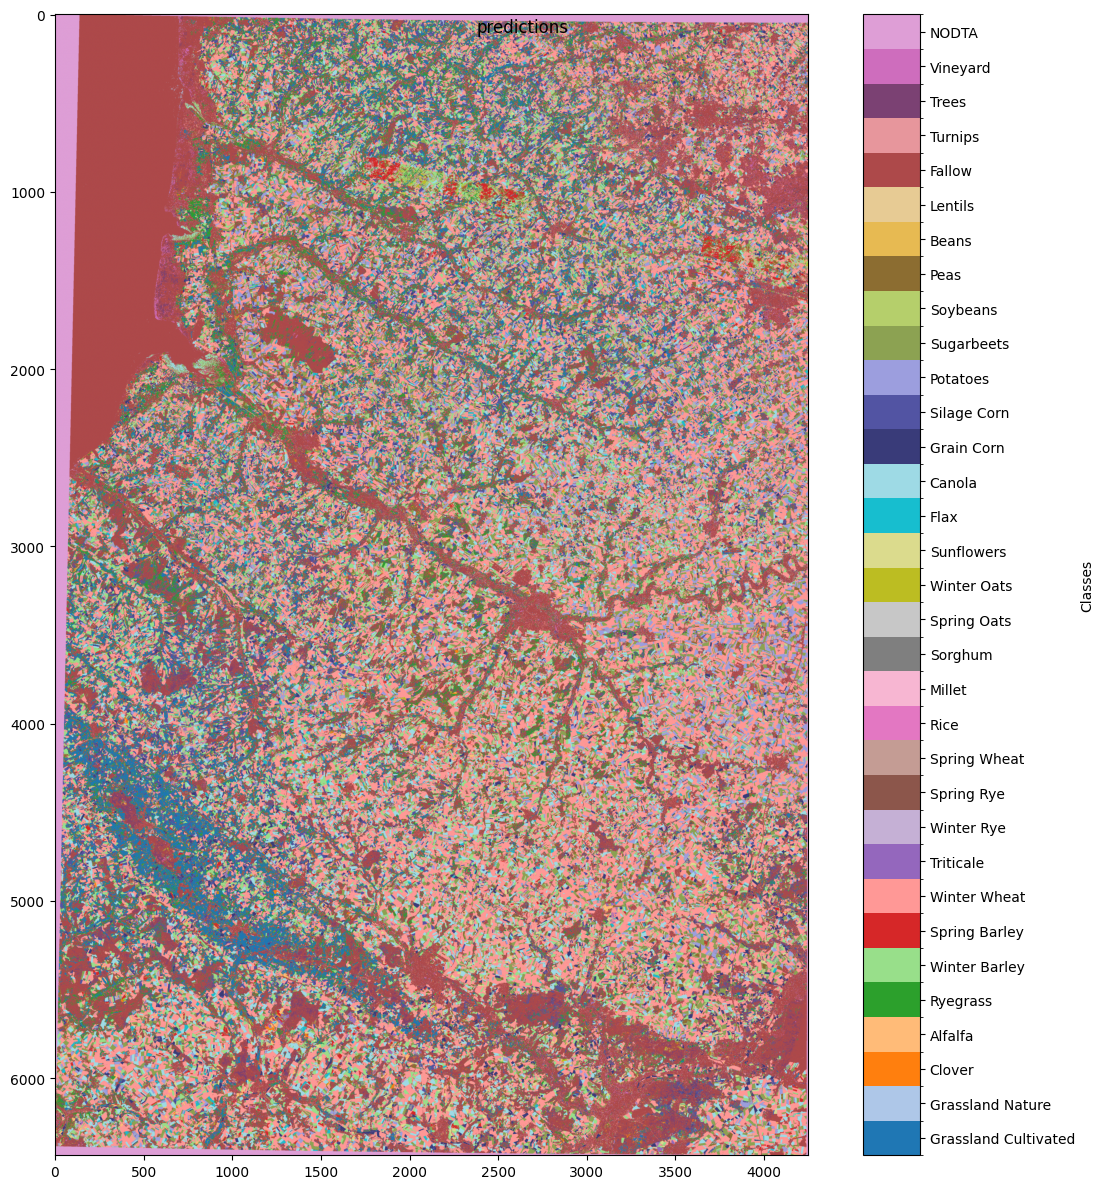

In [52]:
fig, ax = plt.subplots(1,1, figsize=(12, 12))

im = ax.imshow(reprojected_predictions, cmap=classes_cmap, norm=classes_norm)
cbar = plt.colorbar(im, ticks=np.arange(n_predicted_classes+1)) # +1 for nodata
cbar.set_label('Classes')

cbar.set_ticklabels(category_labels)

plt.tight_layout()
plt.suptitle("predictions")

In [ ]:
for annotation in valid_labels:
    chunk = 
    

# Diagnose confusion between crop types and propose a strategy to improve model performance.


# Implement efficient geospatial processing using Rasterio, Geopandas, and parallel computation.


# Provide a structured output and recommendations on how to enhance the training pipeline.
